In [2]:
import os
os.chdir('/home/nmduy/CA683/Credit Project')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import auc
from sklearn import preprocessing
import pandas as pd
import numpy as np
import random
import json
from sklearn import metrics
random.seed(1509)

## Read data
Read filtered csv file (remove features containing too much missing values) and encode the categorical variables.

In [329]:
##### READ DATA #####
data = pd.read_csv('data/application_train.csv')
data_remove_id = data.drop(['SK_ID_CURR'], axis=1) if 'SK_ID_CURR' in list(data.columns) else data.copy()
data_remove_id = data_remove_id.drop(['DAYS_EMPLOYED_ANOM'], axis=1) if 'DAYS_EMPLOYED_ANOM' in list(data_remove_id.columns) else data_remove_id.copy()
data_remove_id = data_remove_id.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in list(data_remove_id.columns) else data_remove_id.copy()

ft_types = dict(data_remove_id.dtypes)

categorical_ft = []
numerical_ft = []
for ft, val in ft_types.items():
    if val == np.object:
        categorical_ft += [ft]
    else:
        numerical_ft += [ft]


In [316]:

select_ft = ['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLOORSMAX_AVG', 
             'DAYS_REGISTRATION', 'AMT_GOODS_PRICE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'HOUR_APPR_PROCESS_START', 
             'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_MON']

drop_numerical_ft = [x for x in numerical_ft if x not in select_ft]
remain_numerical_ft = [x for x in numerical_ft if x not in drop_numerical_ft]
print((len(drop_numerical_ft), len(remain_numerical_ft)))
data_remove_id = data_remove_id.drop(drop_numerical_ft, axis=1)
data_remove_id = data_remove_id.drop(categorical_ft, axis=1)

(92, 13)


In [328]:
encoded_data = pd.get_dummies(data_remove_id)

print(encoded_data.shape)

##### DROP NA #####
encoded_data = encoded_data.dropna()
encoded_data = encoded_data.reset_index(drop=True)
print(encoded_data.shape)

(307511, 245)
(11351, 245)


In [24]:
np.sum(np.isfinite(encoded_data).sum()-190079)

-3

## MAKE THE DATASET
Create subset and maybe make it balance between classes within classes

In [303]:
##### MAKE IT BALANCE #####
random.seed(1509)

numb_pos_samples = encoded_data['TARGET'].sum()
numb_neg_samples = len(encoded_data) - numb_pos_samples
portion_pos_train = 0.8
portion_pos_val = 0.1
numb_pos_train = int(numb_pos_samples * portion_pos_train)
numb_pos_val = int(numb_pos_samples * portion_pos_val)
numb_pos_test = numb_pos_samples - numb_pos_train - numb_pos_val

index_pos = encoded_data.index[encoded_data['TARGET'] == 1].tolist()
index_neg = [i for i in range(len(encoded_data)) if i not in index_pos]

data_pos = encoded_data.iloc[np.asarray(index_pos), :]
data_neg = encoded_data.iloc[np.asarray(index_neg), :]

##### shuffle #####
data_pos = data_pos.sample(frac=1)
data_neg = data_neg.sample(frac=1)

data_pos_train = data_pos.iloc[0:numb_pos_train,:]
data_pos_val = data_pos.iloc[numb_pos_train:numb_pos_train + numb_pos_val, :]
data_pos_test = data_pos.iloc[numb_pos_train + numb_pos_val:, :]

data_neg_train = data_neg.iloc[0:int(numb_pos_train*11), :]
data_neg_val = data_neg.iloc[int(numb_pos_train*11):-numb_pos_test, :]
data_neg_test = data_neg.iloc[-numb_pos_test:, :]

data_train = pd.concat([data_pos_train, data_neg_train], ignore_index=True)
data_val = pd.concat([data_pos_val, data_neg_val], ignore_index=True)
data_not_test = pd.concat([data_train, data_val], ignore_index=True)
data_test = pd.concat([data_pos_test, data_neg_test], ignore_index=True)

print(f"Numb train/val/test samples: {len(data_train)} / {len(data_val)} / {len(data_test)}")

print(data_train.shape)

Numb train/val/test samples: 238320 / 64225 / 4966
(238320, 206)


## REMOVE FEATURE CONTAINING ONLY 1 VALUES

## FILTER CORRELATION MATRIX

In [263]:
corr_pd = abs(data_not_test.corr()['TARGET']).sort_values()
corr_pd = corr_pd[1:]
corr_pd.describe()

In [265]:
corr_dict = dict(corr_pd)

In [274]:
thres = 0.002589
drop_ft = []
for k, v in corr_dict.items():
    if v <= thres:
        drop_ft += [k]
len(drop_ft)


50

In [275]:
data_train = data_train.drop(drop_ft, axis=1)
data_val = data_val.drop(drop_ft, axis=1)
data_test = data_test.drop(drop_ft, axis=1)
data_not_test = data_not_test.drop(drop_ft, axis=1)

## SPLIT DATASET

In [304]:
##### REMOVE 1-VALUE FT #####
remove_ft = []
for col in list(data_not_test.drop('TARGET', axis=1).columns):
    if data_not_test[col].sum() == 0 or data_not_test[col].sum() == len(data_not_test[col]):
        remove_ft += [col]

print(remove_ft)        
print(len(remove_ft))

data_train = data_train.drop(remove_ft, axis=1)
data_val = data_val.drop(remove_ft, axis=1)
data_test = data_test.drop(remove_ft, axis=1)
data_not_test = data_not_test.drop(remove_ft, axis=1)

[]
0


In [305]:
X_train = data_train.drop(['TARGET'], axis = 1)
X_test = data_test.drop(['TARGET'], axis = 1)
X_val = data_val.drop(['TARGET'], axis = 1)
y_train = data_train['TARGET']
y_test = data_test['TARGET']
y_val = data_val['TARGET']
X_not_test = data_not_test.drop(['TARGET'], axis = 1)
y_not_test = data_not_test['TARGET']
print(X_train.shape)

(238320, 205)


## TRAIN
Run classifier on both RandomForest and Logistic Regression

In [306]:
rf = RandomForestClassifier(class_weight='balanced')
lg = LogisticRegression(class_weight='balanced')

rf.fit(X_train, y_train)
lg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluate

In [11]:
def calculate_metric(gtnp, pdnp, score=None):
    # input are numpy vector
    total_samples = len(gtnp)
    #print(f"Total sample: {total_samples}")
    total_correct = np.sum(gtnp == pdnp)
    accuracy = total_correct / total_samples
    gt_pos = np.where(gtnp == 1)[0]
    gt_neg = np.where(gtnp == 0)[0]
    TP = np.sum(pdnp[gt_pos])
    TN = np.sum(1 - pdnp[gt_neg])
    FP = np.sum(pdnp[gt_neg])
    FN = np.sum(1 - pdnp[gt_pos])
    if score is not None:
        AUC = roc_auc_score(gtnp, score)
        lr_precision, lr_recall, _ = precision_recall_curve(gtnp, score)
        AUC_PR = auc(lr_recall, lr_precision)
    else:
        AUC = roc_auc_score(gtnp, pdnp)
        ACU_PR = -1

    
    
    precision = TP / (TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    metrics = {}
    metrics['accuracy'] = str(accuracy)
    metrics['precision'] = str(precision)
    metrics['recall'] = str(recall)
    metrics['f1'] = str(f1)
    metrics['tp'] = str(int(TP))
    metrics['tn'] = str(int(TN))
    metrics['fp'] = str(int(FP))
    metrics['fn'] = str(int(FN))
    metrics['auc'] = str(AUC)
    metrics['auc_pr'] = str(AUC_PR)

    return metrics

### RF Evaluation

In [308]:
##### TRAIN PREDICTION #####
rf_train_predict = rf.predict(X_train)
rf_train_score = rf.predict_proba(X_train)[:,1] # score of higher label
rf_train_metric = calculate_metric(y_train, rf_train_predict, rf_train_score)

##### VALIDATE PREDICTION #####
rf_val_predict = rf.predict(X_val)
rf_val_score = rf.predict_proba(X_val)[:,1] # score of higher label
rf_val_metric = calculate_metric(y_val, rf_val_predict, rf_val_score)

##### TEST PREDICTION #####
rf_test_predict = rf.predict(X_test)
rf_test_score = rf.predict_proba(X_test)[:,1]
rf_test_metric = calculate_metric(y_test, rf_test_predict, rf_test_score)

### Logistic Regression Evaluation

In [309]:
##### TRAIN PREDICTION #####
lg_train_predict = lg.predict(X_train)
lg_train_score = lg.predict_proba(X_train)[:,1] # score of higher label
lg_train_metric = calculate_metric(y_train, lg_train_predict, lg_train_score)

##### VALIDATE PREDICTION #####
lg_val_predict = lg.predict(X_val)
lg_val_score = lg.predict_proba(X_val)[:,1] # score of higher label
lg_val_metric = calculate_metric(y_val, lg_val_predict, lg_val_score)

##### TEST PREDICTION #####
lg_test_predict = lg.predict(X_test)
lg_test_score = lg.predict_proba(X_test)[:,1]
lg_test_metric = calculate_metric(y_test, lg_test_predict, lg_test_score)

In [310]:
result = {}
result['info'] = 'merged app, remove corr25, 148 ft, using all numeric, encoded, dropna, classweight balanced, rf not balanced, negative:positive = 11:1'
result['RF'] = {}
result['LG'] = {}
result['RF']['train'] = rf_train_metric
result['RF']['val'] = rf_val_metric
result['RF']['test'] = rf_test_metric
result['LG']['train'] = lg_train_metric
result['LG']['val'] = lg_val_metric
result['LG']['test'] = lg_test_metric

In [311]:
result['LG']

{'train': {'accuracy': '0.9166666666666666',
  'precision': 'nan',
  'recall': '0.0',
  'f1': 'nan',
  'tp': '0',
  'tn': '218460',
  'fp': '0',
  'fn': '19860',
  'auc': '0.5',
  'auc_pr': '0.5416666666666666'},
 'val': {'accuracy': '0.9613546126897625',
  'precision': 'nan',
  'recall': '0.0',
  'f1': 'nan',
  'tp': '0',
  'tn': '61743',
  'fp': '0',
  'fn': '2482',
  'auc': '0.5',
  'auc_pr': '0.5193226936551187'},
 'test': {'accuracy': '0.5',
  'precision': 'nan',
  'recall': '0.0',
  'f1': 'nan',
  'tp': '0',
  'tn': '2483',
  'fp': '0',
  'fn': '2483',
  'auc': '0.5',
  'auc_pr': '0.75'}}

## TEST

In [273]:
filename = 'metric/result_05.json'
with open(filename, 'w') as f:
    json.dump(result, f)

In [314]:
print(encoded_data_test.shape)

(48744, 203)


In [206]:
encoded_data_test = encoded_data_test.drop(drop_numerical_ft, axis=1)
print(encoded_data_test.shape)

(48744, 124)


In [313]:
data_test = pd.read_csv('data/filtered_merged_application_test.csv')
SK_ID_CURR = data_test['SK_ID_CURR']
data_test = data_test.drop(['SK_ID_CURR'], axis=1) if 'SK_ID_CURR' in list(data_test.columns) else data_test.copy()
data_test = data_test.drop(['DAYS_EMPLOYED_ANOM'], axis=1) if 'DAYS_EMPLOYED_ANOM' in list(data_test.columns) else data_test.copy()
data_test = data_test.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in list(data_test.columns) else data_test.copy()
encoded_data_test = pd.get_dummies(data_test)

In [140]:
drop_ft_test = [x for x in list(encoded_data_test.columns) if x in drop_ft]
encoded_data_test = encoded_data_test.drop(drop_ft_test, axis=1)
print(encoded_data_test.shape)

(48744, 148)


In [208]:
encoded_data_test_fillna = encoded_data_test.fillna(encoded_data_test.mean())

In [214]:
data_test_score = rf.predict_proba(encoded_data_test_fillna)[:,1] # score of higher label

In [215]:
submit = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': data_test_score})
submit.to_csv('data/submit_select_numerical_rf.csv', index=False)

In [165]:
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.10
1,100005,0.12
2,100013,0.05
3,100028,0.02
4,100038,0.14


## Feature Importance RF

In [ ]:
ft_importance = lg.feature_importances_
name_ft = np.asarray(list(X_train.columns))
index_sort = np.argsort(ft_importance)
name_ft[index_sort[::-1]]

In [274]:
varimp = {}
for k, v in zip(list(name_ft[index_sort[::-1]]), list(ft_importance[index_sort[::-1]])):
    varimp[k] = v

In [286]:
varimp_pd = pd.DataFrame(data={'Features': list(name_ft[index_sort[::-1]]), 'Importance': list(ft_importance[index_sort[::-1]])})

In [289]:
varimp_pd_plot = varimp_pd.iloc[:20,:]
varimp_pd_plot

,Features,Importance
0,EXT_SOURCE_2,0.067218
1,EXT_SOURCE_3,0.065138
2,DAYS_BIRTH,0.029492
3,EXT_SOURCE_1,0.026681
4,DAYS_EMPLOYED,0.026094
5,DAYS_LAST_PHONE_CHANGE,0.024322
6,DAYS_ID_PUBLISH,0.023219
7,DIF_DAYS_INSTALMENT_sum,0.022584
8,AMT_ANNUITY,0.021874
9,AMT_CREDIT,0.021842


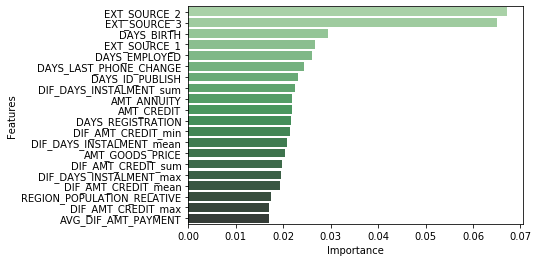

In [290]:
import seaborn as sns
pal = sns.color_palette("Greens_d", len(varimp_pd_plot))
ax = sns.barplot(x="Importance", y="Features", data=varimp_pd_plot, palette=np.array(pal[::-1]))

In [294]:
drop_ft_rf = list(varimp_pd.Features)[68:]


## FIND PVALUES

In [210]:
def calculate_pvalue(X_ft, model):
    #### Get p-values for the fitted model ####
    denom = (2.0*(1.0+np.cosh(model.decision_function(X_ft))))
    denom = np.tile(denom,(X_ft.shape[1],1)).T
    F_ij = np.dot((X_ft/denom).T,X_ft) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    
    index_sort = np.argsort(p_values)
    pnp = np.asarray(p_values)
    name_ft = np.asarray(list(X_ft.columns))
    name_ft_sort = list(name_ft[index_sort])
    p_values_sort = list(pnp[index_sort])

    dict_p = {}
    for k, v in zip(name_ft_sort, p_values_sort):
        dict_p[k] = v

    return dict_p

In [170]:
import scipy.stats as stat

X = X_train_numeric
#### Get p-values for the fitted model ####
denom = (2.0*(1.0+np.cosh(lg.decision_function(X))))
denom = np.tile(denom,(X.shape[1],1)).T
F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
z_scores = lg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

In [171]:
index_sort = np.argsort(p_values)

In [172]:
pnp = np.asarray(p_values)
index_sort[0:8]

array([27, 28, 29, 79,  4,  3, 77,  2])

In [173]:
name_ft = np.asarray(list(X_train.columns))
name_ft_sort = list(name_ft[index_sort])
p_values_sort = list(pnp[index_sort])

In [180]:
dict_p_numeric = {}
for k, v in zip(name_ft_sort, p_values_sort):
    dict_p_numeric[k] = v

In [179]:
dict_p

{'EXT_SOURCE_1': 0.0,
 'EXT_SOURCE_3': 0.0,
 'EXT_SOURCE_2': 0.0,
 'AMT_GOODS_PRICE': 9.820098522495694e-77,
 'AMT_CREDIT': 1.1407936262628576e-68,
 'AMT_ANNUITY': 1.5626788658727285e-66,
 'DAYS_ID_PUBLISH': 1.2808294265046122e-59,
 'DAYS_LAST_PHONE_CHANGE': 1.3434755791576479e-49,
 'OWN_CAR_AGE': 1.3312472771270706e-44,
 'FLAG_WORK_PHONE': 4.678728597223358e-37,
 'FLAG_DOCUMENT_18': 1.25658594570938e-33,
 'AMT_REQ_CREDIT_BUREAU_MON': 5.50167472262478e-32,
 'FLAG_DOCUMENT_16': 1.770963864177591e-30,
 'FLAG_DOCUMENT_3': 2.3357158094270268e-30,
 'AMT_REQ_CREDIT_BUREAU_YEAR': 2.847666702649383e-28,
 'DAYS_BIRTH': 3.963869320629495e-24,
 'REG_CITY_NOT_LIVE_CITY': 2.151350240775224e-23,
 'FLAG_DOCUMENT_6': 1.660561656461565e-18,
 'FLAG_DOCUMENT_13': 7.251753012692594e-17,
 'FLAG_DOCUMENT_15': 1.735271425779289e-16}

In [ ]:
dict_p_numeric

In [176]:
t1 = dict_p.keys()
t2 = dict_p_numeric.keys()
d1 = [x for x in t1 if x not in t2]
d2 = [x for x in t2 if x not in t1]

In [177]:
d1

['DAYS_BIRTH']

In [178]:
d2

['FLAG_DOCUMENT_8']

## DEBUG

In [295]:
##### READ DATA #####
data = pd.read_csv('data/merged_application_train.csv')
data_remove_id = data.drop(['SK_ID_CURR'], axis=1) if 'SK_ID_CURR' in list(data.columns) else data.copy()
data_remove_id = data_remove_id.drop(['DAYS_EMPLOYED_ANOM'], axis=1) if 'DAYS_EMPLOYED_ANOM' in list(data_remove_id.columns) else data_remove_id.copy()
data_remove_id = data_remove_id.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in list(data_remove_id.columns) else data_remove_id.copy()

ft_types = dict(data_remove_id.dtypes)

categorical_ft = []
numerical_ft = []
for ft, val in ft_types.items():
    if val == np.object:
        categorical_ft += [ft]
    elif ft != 'TARGET':
        numerical_ft += [ft]


select_ft = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLOORSMAX_AVG', 
             'DAYS_REGISTRATION', 'AMT_GOODS_PRICE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'HOUR_APPR_PROCESS_START', 
             'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_MON']

drop_numerical_ft = [x for x in numerical_ft if x not in select_ft]

print(data_remove_id.shape)

(307511, 147)


In [296]:
data_test = pd.read_csv('data/merged_application_test.csv')
SK_ID_CURR = data_test['SK_ID_CURR']
data_test = data_test.drop(['SK_ID_CURR'], axis=1) if 'SK_ID_CURR' in list(data_test.columns) else data_test.copy()
data_test = data_test.drop(['DAYS_EMPLOYED_ANOM'], axis=1) if 'DAYS_EMPLOYED_ANOM' in list(data_test.columns) else data_test.copy()
data_test = data_test.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in list(data_test.columns) else data_test.copy()
print(data_test.shape)


(48744, 146)


In [297]:
y_train = data_remove_id['TARGET']
data_remove_id = data_remove_id.drop('TARGET', axis=1)
X_train_numeric = data_remove_id.drop(categorical_ft, axis=1)
X_train_categori = data_remove_id.drop(numerical_ft, axis=1)
X_test_numeric = data_test.drop(categorical_ft, axis=1)
X_test_categori = data_test.drop(numerical_ft, axis=1)

######
#X_train_numeric = X_train_numeric.drop(drop_numerical_ft, axis=1)
#X_test_numeric = X_test_numeric.drop(drop_numerical_ft, axis=1)
######

X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
X_test_numeric = X_test_numeric.fillna(X_train_numeric.median())

X_train_categori = pd.get_dummies(X_train_categori)
X_test_categori = pd.get_dummies(X_test_categori)

In [298]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_numeric)
X_train_numeric_scaled = scaler.transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)
X_train_numeric = pd.DataFrame(data=X_train_numeric_scaled, columns=list(X_train_numeric.columns))
X_test_numeric = pd.DataFrame(data=X_test_numeric_scaled, columns=list(X_test_numeric.columns))

In [299]:
X_train = pd.concat([X_train_numeric, X_train_categori], axis=1)
X_test = pd.concat([X_test_numeric, X_test_categori], axis=1)
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
print(X_train.shape)
print(X_test.shape)

(307511, 267)
(48744, 267)


In [37]:
temp = X_train.copy()
temp['TARGET'] = y_train
corr_pd = abs(temp.corr()['TARGET']).sort_values()
corr_pd = corr_pd[:-1]
corr_pd.describe()

count    267.000000
mean       0.017143
std        0.020712
min        0.000074
25%        0.003376
50%        0.010266
75%        0.023899
max        0.160295
Name: TARGET, dtype: float64

In [38]:
corr_dict = dict(corr_pd)
thres = 0.010266
drop_ft = []
for k, v in corr_dict.items():
    if v <= thres:
        drop_ft += [k]
len(drop_ft)
X_train = X_train.drop(drop_ft, axis=1)
X_test = X_test.drop(drop_ft, axis=1)

In [300]:
## DROP FT FROM RF
X_train = X_train.drop(drop_ft_rf, axis=1)
print(X_train.shape)

(307511, 68)


In [301]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [302]:
print(X_train.shape)
lg_predict = lg.predict(X_train)
lg_score = lg.predict_proba(X_train)[:,1]
lg_metric = calculate_metric(y_train, lg_predict, lg_score)

(307511, 68)


In [303]:
lg_metric

{'accuracy': '0.6866973864349568',
 'precision': '0.15904691984248814',
 'recall': '0.6719436052366566',
 'f1': '0.25721246511341034',
 'tp': '16681',
 'tn': '194486',
 'fp': '88200',
 'fn': '8144',
 'auc': '0.743007598259023',
 'auc_pr': '0.21907134330640465'}

In [304]:
pred_test = lg.predict_proba(X_test.drop(drop_ft_rf, axis=1))[:,1]

In [305]:
submit = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': pred_test})
submit.to_csv('data/submit_exp_13.csv', index=False)

In [249]:
dict_p = calculate_pvalue(X_train_numeric, lg)

In [250]:
import math
list_ft_p_bad = []
for k, v in dict_p.items():
    if v > 0.05 or math.isnan(v):
        list_ft_p_bad += [k]    

In [251]:
X_train_again = X_train_numeric.drop(list_ft_p_bad, axis=1)
print(X_train_again.shape)

(307511, 45)


In [252]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train_again, y_train)
print(X_train_again.shape)
lg_predict = lg.predict(X_train_again)
lg_score = lg.predict_proba(X_train_again)[:,1]
lg_metric = calculate_metric(y_train, lg_predict, lg_score)

(307511, 45)


In [247]:
lg_metric

{'accuracy': '0.6863982101453281',
 'precision': '0.15840639578702334',
 'recall': '0.6688418932527694',
 'f1': '0.2561476042084478',
 'tp': '16604',
 'tn': '194471',
 'fp': '88215',
 'fn': '8221',
 'auc': '0.7404515963997476',
 'auc_pr': '0.21352138359979536'}

In [240]:
X_test_again = X_test_numeric.drop(list_ft_p_bad, axis=1)
pred_test = lg.predict_proba(X_test_again)[:,1]
submit = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': pred_test})
submit.to_csv('data/submit_exp_10.csv', index=False)

In [241]:
dict_p = calculate_pvalue(X_train_again, lg)

In [242]:
dict_p

{'EXT_SOURCE_3': 0.0,
 'EXT_SOURCE_2': 0.0,
 'EXT_SOURCE_1': 0.0,
 'AMT_GOODS_PRICE': 4.064740805903562e-256,
 'AMT_CREDIT': 1.0910911912421058e-223,
 'FLAG_DOCUMENT_3': 1.5204490084117984e-154,
 'OCCUPATION_TYPE_Drivers': 4.629329676854047e-123,
 'AVG_DIF_AMT_PAYMENT': 7.278184996804162e-113,
 'DAYS_LAST_PHONE_CHANGE': 1.4027524132825983e-106,
 'OCCUPATION_TYPE_Laborers': 1.2195744139833957e-86,
 'DAYS_ID_PUBLISH': 1.2757359875025942e-68,
 'FLAG_WORK_PHONE': 1.1763083090568134e-58,
 'REGION_RATING_CLIENT_W_CITY': 3.3766128356020325e-51,
 'FLAG_DOCUMENT_6': 1.3123848675990174e-50,
 'FLAG_DOCUMENT_18': 1.8602538620516663e-46,
 'OCCUPATION_TYPE_Core staff': 5.767756127670246e-43,
 'AMT_ANNUITY': 6.757744023541525e-42,
 'OCCUPATION_TYPE_Security staff': 5.434907500295979e-41,
 'FLAG_DOCUMENT_16': 3.2837245158817866e-38,
 'REG_CITY_NOT_LIVE_CITY': 3.0062619976116493e-37,
 'FLAG_DOCUMENT_13': 2.9592350620479976e-36,
 'OCCUPATION_TYPE_Low-skill Laborers': 2.1882708902380844e-35,
 'DIF_AMT_CR

In [232]:
import math
math.isnan(dict_p['ORGANIZATION_TYPE_Industry: type 13'])

True